In [1]:
# Data Processing Libraries
import pandas as pd
import os
import csv
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

# Model Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import regularizers

2023-12-11 23:14:51.459271: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Model Data 
Checkpoint: Load cached data here

In [2]:
# Test Loading Data
model_data_df = pickle.load(open('../data/model_data.pkl', 'rb'))
model_data_df

,race,sample_data,label
0,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
1,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
2,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
3,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
4,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
...,...,...,...
1495,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1496,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1497,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1498,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"


### Preprocess Data

In [3]:
# ONE HOT ENCODE DATA
encoded_labels = pd.get_dummies(model_data_df.label)
encoded_df = model_data_df.join(encoded_labels)


In [4]:
# Filter Data Frames by Race 
white_df = encoded_df[encoded_df["race"] == "white"]
black_df = encoded_df[encoded_df["race"] == "black or african american"]
asian_df = encoded_df[encoded_df["race"] == "asian"]
prognosis_names = encoded_df.label.unique()

# Train Test Split
def df_split(df): 
    split_index = int(0.7 * len(df)) 
    return df.iloc[:split_index], df.iloc[split_index:]

train_white_df, test_white_df = df_split(white_df) 
train_black_df, test_black_df = df_split(black_df) 
train_asian_df, test_asian_df = df_split(asian_df)

# Concatenate Final Sets 
train_df = train_white_df
# train_df = pd.concat([train_white_df, train_black_df, train_asian_df])

### Model Results for (train white, test black / asian)

In [5]:
# Prepare Model Data --> [takes 1 min. 15 sec.]
def get_x_y(df, prognosis_names): 
    x = np.stack(df.sample_data.values)
    y = df.filter(prognosis_names).values
    return x, y

def train_val_split(data):
    # returns: x_train, x_val, y_train, y_val
    x, y = data
    return train_test_split(x, y, test_size=0.15, random_state=42)


##### Main Code #########
x_train, x_val, y_train, y_val = train_val_split(get_x_y(train_df, prognosis_names)) # training data

x_test_white, y_test_white = get_x_y(test_white_df, prognosis_names)
x_test_black, y_test_black = get_x_y(test_black_df, prognosis_names)
x_test_asian, y_test_asian = get_x_y(test_asian_df, prognosis_names)

In [11]:
# TRAIN NEURAL NETWORK
num_classes = model_data_df.label.nunique()

# Basic DNN Model 
reg_rate = 0.1
model = Sequential([
    Flatten(input_shape=(60623, 26)),  # Flattening the input
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/15
19/19 [==============================] - 34s 2s/step - loss: 125.6702 - accuracy: 0.4203 - val_loss: 81.5395 - val_accuracy: 0.6822
Epoch 2/15
19/19 [==============================] - 28s 1s/step - loss: 62.5776 - accuracy: 0.4419 - val_loss: 51.5592 - val_accuracy: 0.6822
Epoch 3/15
19/19 [==============================] - 27s 1s/step - loss: 40.4080 - accuracy: 0.4950 - val_loss: 27.1685 - val_accuracy: 0.6729
Epoch 4/15
19/19 [==============================] - 27s 1s/step - loss: 28.7446 - accuracy: 0.5249 - val_loss: 30.1661 - val_accuracy: 0.2804
Epoch 5/15
19/19 [==============================] - 27s 1s/step - loss: 25.4549 - accuracy: 0.6096 - val_loss: 22.2290 - val_accuracy: 0.6822
Epoch 6/15
19/19 [==============================] - 27s 1s/step - loss: 25.2402 - accuracy: 0.5631 - val_loss: 19.3461 - val_accuracy: 0.3925
Epoch 7/15
19/19 [==============================] - 27s 1s/step - loss: 14.3319 - accuracy: 0.6561 - val_loss: 8.9865 - val_accuracy: 0.7103
Epoch 

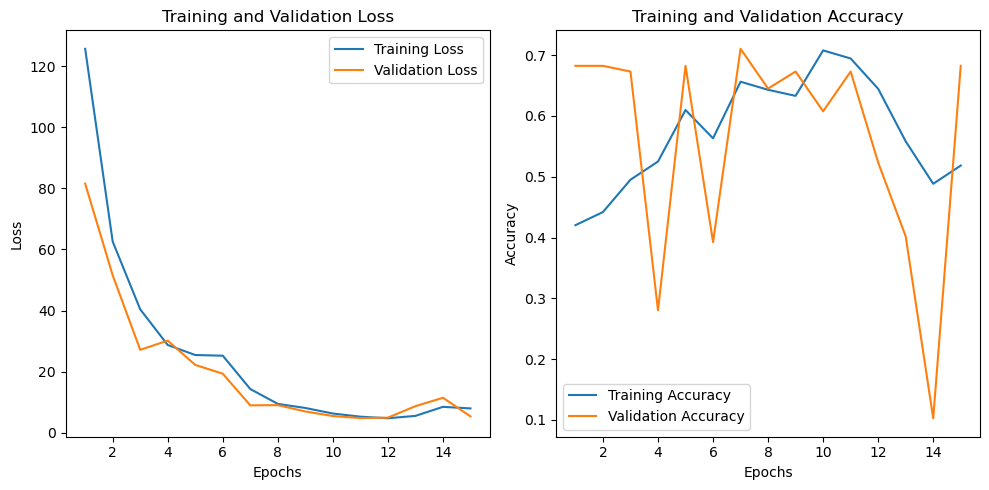

In [12]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Check Test Performance - Black & AA Patients
evaluation = model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 72ms/step - loss: 5.2742 - accuracy: 0.8205
Performance on Black Patients
----------------------------------
Loss on test data: 5.274219036102295
Accuracy on test data: 0.8205128312110901


In [15]:
# Check Test Performance - Asian Patients
evaluation = model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 239ms/step - loss: 3.6166 - accuracy: 0.8214
Performance on Asian Patients
----------------------------------
Loss on test data: 3.6165668964385986
Accuracy on test data: 0.8214285969734192
